<font size=6>**Gaussian Processes**</font>

<div style="border: 1px solid lightgray; padding: 10px; background-color: #f9f9f9;">

<font size=1>

    Summer School for AstroStatistics in Crete, 2025

The content presented in this notebook is the original work of the authors, unless specified otherwise.
Any publicly available material incorporated is properly credited to its respective sources.
All references to published papers, datasets, and software tools are duly acknowledged.
The original content of this notebook is licensed under the GNU General Public License v3.0 (GNU GPLv3).
</font>
</div>

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

This notebook presents **Gaussian Processes**, a fitting method that has countless applications in Statistics and ML.

Notably, it has <u>2 properties</u> we will exploit:
- it can bu used to fit a **black-box function**
- it naturally provides **uncertainties** on the model

**<u>Applications:</u>**

> _Gaussian Processes is very powerful on its own, being a generic fitting method for any **regression task**._

However ..

> _We will also see how it shines when incorporated in **Bayesian Optimization**, a technique we will use for <u>hyperparameter optimization</u>._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set up a fancy plot style (you can comment it out without consequences)
import sys; sys.path.append('../src'); import plot_style

# Preamble: $n$ function points are equal to 1 point in $\mathbb{R}^{n}$

Let's assume we have a **unknown function** $-$ the one we want to model $-$ $f(x)$, where $x$ is 1D.

> <i>IMPORTANT: We do <u>not</u> know the functional form of $f$ !</i>

We only know that, for every point $x_i$, we can generate a corresponding $y_i \equiv f(x_i)$

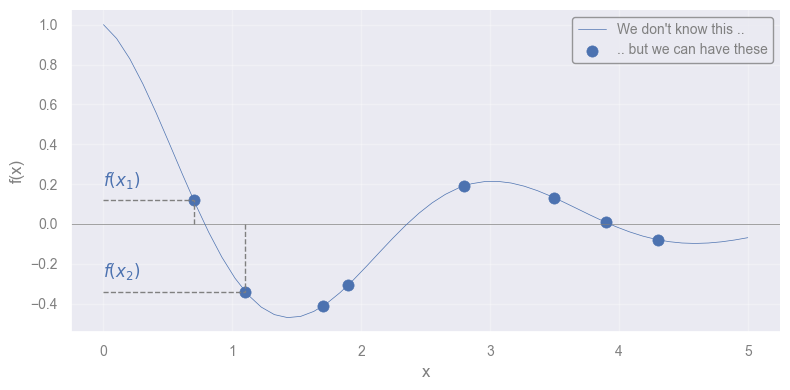

In [3]:
# Unknown function of extra-terrestrial origin:
def f(x):
    return np.exp(-0.5 * x) * np.cos(2 * x)
'''NOTE: You have to pretend we do _not_ know the mathematical form.
         Just use this `f(x)` as a black-box function.'''

xx = np.linspace(0, 5, 50)
X = np.array([0.7, 1.1, 1.7, 1.9, 2.8, 3.5, 3.9, 4.3])

plt.figure()
plt.axhline(y=0, lw=0.5, c='grey')
plt.plot(xx, f(xx), c='C0', lw=0.5, label="We don't know this ..")
plt.scatter(X, f(X), c='C0', s=65, lw=0.5, label=".. but we can have these")
plt.xlabel('x')
plt.ylabel('f(x)')

for i in range(2):
    plt.plot([X[i], X[i]], [0, f(X[i])], ls='--', c='grey', lw=1)  # Vertical segment to curve
    plt.plot([0, X[i]], [f(X[i]), f(X[i])], ls='--', c='grey', lw=1)  # Horizontal segment to y-axis
    plt.text(0, f(X[i])+0.1, str("$f(x_%s)$" % (i+1)), c='C0', fontsize=12, verticalalignment='center')

plt.legend()
plt.show()

We can see the array composed of the $n$ values:

$$[f(x_1), f(x_2),\dots, f(x_n)] = [0.16, -0.38, ...]$$ 

as 1 point in $\mathbb{R}^{n}$ &emsp; (_but we can show only the first 2 dimensions_)

In [4]:
# Define grid
fx1x1 = np.linspace(-0.0, 0.5, 50)
fx2x2 = np.linspace(-0.5, 0.0, 50)

fX1, fX2 = f(X[0]), f(X[1])

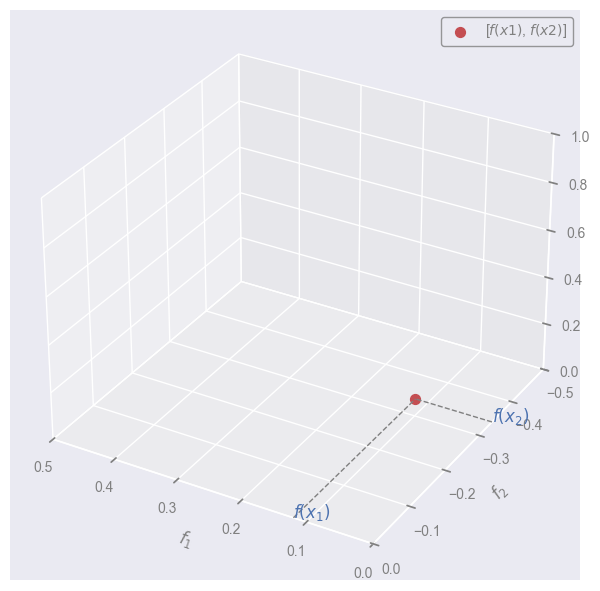

In [5]:
from mpl_toolkits.mplot3d import Axes3D

def plot_point_in_Rn(fX1, fX2, fx1x1, fx2x2, rv=None):
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the point of interest
    ax.scatter(fX1, fX2, 0, color='C3', s=50, label="[$f(x1)$, $f(x2)$]")
    
    # Segmented lines to x- and y-axis
    ax.plot([fX1, fX1], [np.min(fx1x1), fX2],   [0, 0], ls='--', c='grey', lw=1)  # Horizontal line to x-axis
    ax.plot([np.min(fx1x1), fX1],   [fX2, fX2], [0, 0], ls='--', c='grey', lw=1)  # Horizontal line to y-axis
    
    ax.text(fX1, np.min(fx1x1), 0, r"$f(x_1)$", fontsize=12, color='C0')
    ax.text(np.min(fx1x1), fX2, 0, r"$f(x_2)$", fontsize=12, color='C0')
    
    ax.set_xlabel('$f_1$')
    ax.set_ylabel('$f_2$')
    ax.set_xlim([np.max(fx1x1), np.min(fx1x1)]) #  Flip for better visualization
    ax.set_ylim([np.max(fx2x2), np.min(fx2x2)]) #  Flip for better visualization
    ax.set_zlim([0, 1]) # Set view above plane

    if rv:
        # Extract the 2D marginal mean and covariance
        rv_2D = multivariate_normal(mean=mu[:2], cov=sigma[:2, :2])

        # Compute probability density function on a grid
        fX1X1, fX2X2 = np.meshgrid(fx1x1, fx2x2)        
        Z = rv_2D.pdf(np.dstack((fX1X1, fX2X2)))

        # Plot the Multivariate Normal Distribution
        ax.plot_wireframe(fX1X1, fX2X2, Z, color='C2', linewidth=0.5, label='Multinormal')
        
        ax.set_zlim([0, np.max(Z)])
        
    plt.legend()
    plt.show()

plot_point_in_Rn(fX1, fX2, fx1x1, fx2x2, rv=None)

<u>NOTE:</u>

- $f_1$: space of all the possible values that the unknown function <u>may</u> have at point $x_1$ 
- $f_2$: space of all the possible values that the unknown function <u>may</u> have at point $x_2$ 
- $f(x_1)$: actual value that the unknown function <u>has</u> at point $x_1$ 
- $f(x_2)$: actual value that the unknown function <u>has</u> at point $x_2$ 

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

Let's now <u>assume</u> that **f** = $[f(x_1), f(x_2),\dots, f(x_n)]$ is a point that follows a **multivariate Gaussian** (Normal) distribution in $\mathbb{R}^{n}$.

> _In other words, we assume that **f** is sampled from a multivariate Normal_

Let's throw an _arbitrary_ multivariate Normal in the image:

In [6]:
from scipy.stats import multivariate_normal
rng = np.random.default_rng(seed=42)

n_dim = len(X)
# the number of dimensions equals the number of datapoints

# Define Multivariate Normal Distribution
mu = f(X) + rng.uniform(0.05, 0.1, size=n_dim)  # Random means vector (conveniently near the true values)
cov = 0.05*rng.random((n_dim, n_dim))  # Random covariance
sigma = np.dot(cov, cov.T)  # Ensure it's positive semi-definite
#
rv = multivariate_normal(mean=mu, cov=sigma)

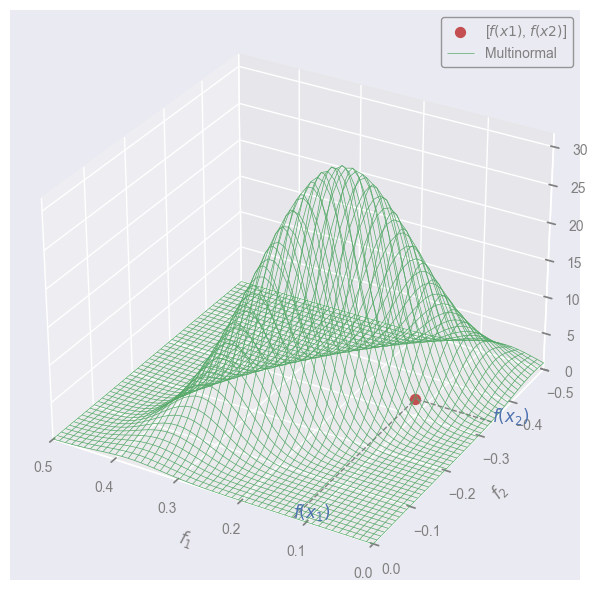

In [7]:
plot_point_in_Rn(fX1, fX2, fx1x1, fx2x2, rv=rv)

We can pretend that the red dot (**f**) is sampled at random from this distribution.

<u>NOTE:</u>

A set of variables is **multivariate** (= **jointly**) **Normal** $\leftrightarrow$ every linear combination of them is normally distributed

$\rightarrow$ the projections (**"marginalizations"**) of the multivariate are <u>also Normal</u> (in 1D):

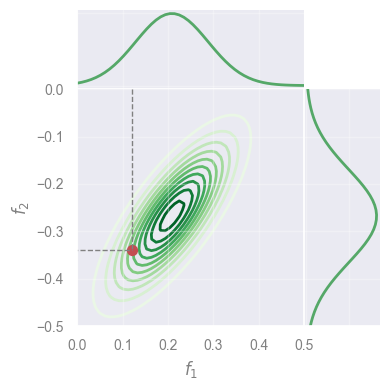

In [8]:
def plot_marginals(fx1x1, fx2x2, rv, mu, f=None, X=None):
    # Extract the 2D marginal mean and covariance
    rv_2D = multivariate_normal(mean=mu[:2], cov=sigma[:2, :2])

    # Compute probability density function on a grid
    fX1X1, fX2X2 = np.meshgrid(fx1x1, fx2x2)        
    Z = rv_2D.pdf(np.dstack((fX1X1, fX2X2)))

    # Generate marginal distributions
    marginal_f1 = multivariate_normal(mu[0], sigma[0][0])
    marginal_f2 = multivariate_normal(mu[1], sigma[1][1])
    marg_f1_vals = marginal_f1.pdf(fx1x1)
    marg_f2_vals = marginal_f2.pdf(fx2x2)
    
    # Create figure;
    if not f:
        n_rows = 2
        n_cols = 2
        figsize = (4, 4)
        gridspec_kw={'height_ratios': [1, 3], 'width_ratios': [3, 1], 'hspace': 0, 'wspace': 0}
    else:
        n_rows = 2
        n_cols = 4
        figsize = (10, 4)
        gridspec_kw={'height_ratios': [1, 3], 'width_ratios': [3, 1, 1, 6], 'hspace': 0, 'wspace': 0}

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, gridspec_kw=gridspec_kw)
    
    axes[0, 1].axis('off')
    ax_marg_x = axes[0, 0]
    ax_joint  = axes[1, 0]
    ax_marg_y = axes[1, 1]

    if f:
        axes[0, 2].axis('off')
        axes[0, 3].axis('off')
        axes[1, 2].axis('off')
        ax_f = fig.add_subplot(axes[1, 3])

    # Contour plot in central panel
    contour = ax_joint.contour(fX1X1, fX2X2, Z, levels=10, cmap='Greens', zorder=-1)
    
    # Plot the point of interest
    ax_joint.scatter(fX1, fX2, color='C3', s=50, label="[$f(x1)$, $f(x2)$]", zorder=1)
    ax_joint.plot([fX1, fX1], [np.min(fx1x1), fX2], ls='--', c='grey', lw=1)
    ax_joint.plot([np.min(fx2x2), fX1], [fX2, fX2], ls='--', c='grey', lw=1)
    
    ax_joint.set_xlim([np.min(fx1x1), np.max(fx1x1)])
    ax_joint.set_ylim([np.min(fx2x2), np.max(fx2x2)])
    ax_joint.set_xlabel('$f_1$')
    ax_joint.set_ylabel('$f_2$')
    
    # Marginal distributions
    ax_marg_x.plot(fx1x1, marg_f1_vals, color='C2')
    ax_marg_x.set_xlim([np.min(fx1x1), np.max(fx1x1)])
    ax_marg_x.set_xticklabels([])
    ax_marg_x.set_yticklabels([])
    
    ax_marg_y.plot(marg_f2_vals, fx2x2, color='C2')
    ax_marg_y.set_ylim([np.min(fx2x2), np.max(fx2x2)])
    ax_marg_y.set_xticklabels([])
    ax_marg_y.set_yticklabels([])

    if f:
        xx = np.linspace(0, 5, 50)
        ax_f.plot(xx, f(xx), c='C0', lw=0.5, label="We don't know this ..")
        
        ax_f.axhline(y=0, lw=0.5, c='grey')
        ax_f.scatter(X, f(X), c='C0', s=65, lw=0.5, label="Data")
        ax_f.set_xlabel('x')
        ax_f.set_ylabel('f(x)')

        # Plot sampled points
        fX_samples = rv.rvs(size=10, random_state=rng)
        ax_joint.scatter(fX_samples[:, 0], fX_samples[:, 1], color='C1', s=30, zorder=1)

        for fX_sample in fX_samples:
            ax_f.scatter(X, fX_sample, c='C4', s=30, lw=0.5, label="Data", alpha=0.5)
                
    plt.show()
    
plot_marginals(fx1x1, fx2x2, rv, mu, f=None, X=None)

# Gaussian Processes

> _A **Gaussian Process (GP)** is a distribution over functions._

We assign probabilities to entire functions $\rightarrow$ any function _sampled_ from a GP is a possible "realization" of a stochastic process.

## Definition

A function **f(x)** is distributed according to a **GP** if:<br>
> _for any set of input points $[x_1, \dots, x_n]$, the corresponding set of function values **[ f(x$_1$), ..., f(x$_n$) ]** <u>follows a multivariate Gaussian</u> (Normal) distribution._

$\rightarrow$ Yes, just like we visualized above!

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

Simliarly, we can sample other points from the same distribution, and plot them:

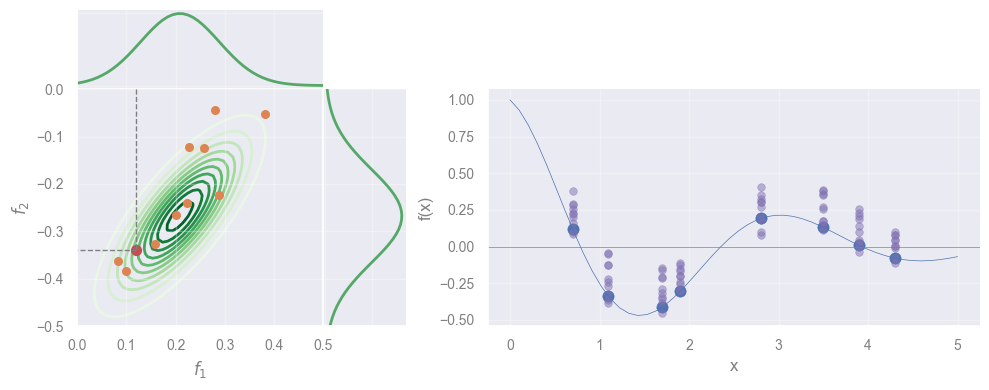

In [9]:
plot_marginals(fx1x1, fx2x2, rv, mu, f=f, X=X)

However, we see that the sampled points **do not** follow the data.

$\rightarrow$ Solving GP means to find the <u>correct</u> Gaussian that describes the data.

> If we do, we can predict the function at any $x_*$!

## Intuition

But ... how can we find the whole Gaussian by using only 1 datapoint (_the red one_)?

**Key idea**: Function values at different points are not $i.i.d.$ but instead exhibit covariance.

$\rightarrow$ When sampling from a GP, we effectively draw an entire set of function values [$f(x_1), \dots, f(x_n)$], not just independent values at each point $x$.

## In mathematical terms

If a function is sampled from a GP, we write:

$$
f \sim \mathcal{GP}(m(x), k(x, x')),
$$

where:

- **$m(x)$** is the **mean function** $-$ gives the expected value of $f(x)$ at any $x$
- **$k(x, x')$** is the "**covariance**" (or "**kernel**") $-$ tells how much the function values at $x$ and $x'$ are expected to vary together
 
Equivalently $-$ we say that **f** = $[f(x_1), f(x_2),\dots, f(x_n)]$ is sampled from a multivariate Normal $\mathcal{N}$:

$$
\begin{bmatrix} f(x_1) \\ f(x_2) \\ \vdots \\ f(x_n) \end{bmatrix} 
\sim \mathcal{N} \left( 
\begin{bmatrix} m(x_1) \\ m(x_2) \\ \vdots \\ m(x_n) \end{bmatrix}, 
\begin{bmatrix} k(x_i, x_j) \end{bmatrix}_{i,j}
\right).
$$

with mean $m(x)$ and covariance $k(x, x')$.

Or, in a more compact form:

$$
\text{\textbf{f}} \sim \mathcal{N} \left(\textbf{m}, K\right).
$$

This will be our **model**.

## Problem Statement

> _**Objective:** Find the model's best **m** and **K** that allow to approximate the <u>unknown</u> function $f(x)$_

Our observables are a set of inputs:
$$ X = \{ x_1, x_2, \dots, x_n \} ~~~,~~~ x_i \in \mathbb{R}^{n} $$

and corresponding outputs:
$$ \text{\textbf{y}} = [y_1, y_2, \dots, y_n]^T  ~~~,~~~ y_i \in \mathbb{R} $$

**Assumption 1:** The observed $y_i$ are not error-less $-$ instead, they are **noisy** realizations of $f(x)$:


$$ y_i = f(x_i) + \epsilon_i ~~~,~~~ \epsilon_i \sim \mathcal{N}(0, \sigma^2_n) \tag{1}$$

- "f" $\rightarrow$ true function values (_unknown_)
- "y" $\rightarrow$ observed function values

**Assumption 2:** $\epsilon_i$ are independent Gaussian noise terms with variance $\sigma^2_n$

(_Yes, a lot of different Gaussians are involved!_)

## Solving GP

<u>**Inference of test points**</u>

Now, suppose we wish to predict **$f_*$** = $f(x_*)$ at new test point $x_*$ $\rightarrow$ we have to <u>extend</u> **f** to a new array:

$$\begin{bmatrix} \text{\textbf{f}} \\ f_* \end{bmatrix}$$

Since $-$ _by definition_ $-$ any finite collection of function values in a GP follows a multivariate Normal:

$$
\begin{bmatrix} \text{\textbf{f}} \\ f_* \end{bmatrix} \sim \mathcal{N} \left(
\begin{bmatrix} \text{\textbf{m}} \\ m_* \end{bmatrix},
\begin{bmatrix} K & k_* \\ k_*^T & k_{**} \end{bmatrix}
\right),
\tag{2}
$$

where:

- $m_*$ is the mean vector evaluated at $x_*$,
- $K$ is the  $n \times n$ covariance matrix on $X$,
- $k_* = [k(x_∗,x_1), \dots, k(x_∗,x_n)]^T$ is the covariance vector between the test point and the training points,
- $k_{∗∗} = k(x_∗,x_∗)$ is the variance at the test point.

Of course, we don't have the array **f**, but **y** (_our observations_) $\rightarrow$ we actually modify Eq. 2 to include **y**:

$$\begin{bmatrix} \text{\textbf{y}} \\ f_* \end{bmatrix} \sim \dots~?\tag{3}$$



<u>**Deriving the posterior**</u>

Our goal is to obtain the "**posterior distribution**", i.e., $p(f_* | y)$ $\rightarrow$ If we have that, we can infer $f_*$ for any new $x_*$.

Let's derive it $-$ Starting form Eq. 1:

$$
\text{\textbf{y}} \sim \text{\textbf{f}} + \boldsymbol{\epsilon} ~~~,~~~ \boldsymbol{\epsilon} \sim \mathcal{N} \left(0, \sigma^2_n I\right).
$$

Since $\text{\textbf{f}} \sim \mathcal{N} \left(\textbf{m}, K\right)$ and the noise $\epsilon_i$ is Gaussian, the observed data $y$ is also Gaussian:

$$
\text{\textbf{y}} \sim \mathcal{N} \left(\textbf{m}, K + \sigma^2_n I\right).
\tag{4}
$$

with variance equalling the sum of variances of **f** and $\epsilon_i$.

Plugging this into Eq. 2, we get:
$$
\begin{bmatrix} \text{\textbf{y}} \\ f_* \end{bmatrix} \sim \mathcal{N} \left(
\begin{bmatrix} \text{\textbf{m}} \\ m^* \end{bmatrix},
\begin{bmatrix} K + \sigma_n^2 I & k_* \\ k_*^T & k_{**} \end{bmatrix}
\right).
\tag{5}
$$

For a joint Normal like the one in Eq. 5, there is a rule to derive the conditional probability ...

<div class="alert alert-info" role="alert" style="border-radius: 8px; padding: 10px;">
<details>
    
<b><summary>[Detailed derivation] (click here to expand)</summary></b>
    
$$
\begin{bmatrix} a \\ b \end{bmatrix} \sim \mathcal{N}\!\Biggl(
\begin{bmatrix} \mu_a \\ \mu_b \end{bmatrix},
\begin{bmatrix} \Sigma_{aa} & \Sigma_{ab} \\ \Sigma_{ba} & \Sigma_{bb} \end{bmatrix} \Biggr)
$$

$$
b \mid a \;\sim\; \mathcal{N}\!\Bigl(\mu_{b|a},\, \Sigma_{b|a}\Bigr),
$$

$$
\text{where}\quad \mu_{b|a} \;=\; \mu_b \;+\; \Sigma_{ba}\,\Sigma_{aa}^{-1}\,\bigl(a-\mu_a\bigr),
\quad \Sigma_{b|a} \;=\; \Sigma_{bb} \;-\; \Sigma_{ba}\,\Sigma_{aa}^{-1}\,\Sigma_{ab}.
$$

We identify, in our case:

$$
\begin{aligned}
a &= \text{\textbf{y}}, \quad \mu_a = \text{\textbf{m}}, \quad \Sigma_{aa} = K + \sigma_n^2 I,\\
b &= f_\ast, \quad \mu_b = m_\ast, \quad \Sigma_{ba} = k_\ast, \quad \Sigma_{ab} = k_\ast^T, \quad \Sigma_{bb} = k_{\ast\ast}.
\end{aligned}
$$

</details>
</div>

... which gives:

$$
f_* \mid \mathbf{y} \;\sim\; 
\mathcal{N}\!\Bigl(m_* + k_*\,(K + \sigma_n^2\,I)^{-1}(\text{\textbf{y}} - \text{\textbf{m}}),\; 
k_{**} - k_* \,(K + \sigma_n^2\,I)^{-1} k_*^T\Bigr).
\tag{6}
$$

$\rightarrow$ To predict $f_*$ at point $x_*$, we will sample from this Multinormal! $\blacksquare$

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

**Q:** BTW, what does it even mean to "condition" a multivariate Normal? (_in-class discussion_)

<div class="alert alert-danger" role="alert" style="border-radius: 8px; padding: 10px;">
<details>
    
<b><summary>[Spoiler] (click here to expand)</summary></b>
    
_Sorry, you should have attended in class, for this!_

</details>
</div>

## Interpretation

$$
\text{posterior mean} ~~~~~~ m_*^{\text{post}} = m_* + k_*\,\bigl(K + \sigma_n^2\,I\bigr)^{-1}\,\bigl(\text{\textbf{y}} - \text{\textbf{m}}\bigr)
$$

> _is our best estimate for the function values at the test inputs $x_*$_

$$
\text{posterior covariance} ~~~~~~ \Sigma_*^{\text{post}} = k_{**} - k_*\,\bigl(K + \sigma_n^2\,I\bigr)^{-1}\,k_*^T
$$

> _quantifies our uncertainty about these estimates_

<br>

<u>**The kernel**</u>

What was $k(x, x')$, again?

> "_tells how much the function values at $x$ and $x'$ are expected to vary together_" = covariance between $f(x)$ and $f(x')$

In practice, we don't know $\rightarrow$ we _assume_ a function, e.g., the [Radial Basis Function (RBF) kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html):

$$
k(x, x') = \exp \left( -\frac{||x - x'||^2}{2\ell^2} \right),
$$

## Completing the derivation

**Yes,**

&emsp; _Eq. 6_

**But,**

&emsp; _we forgot a detail_

$\rightarrow$ We need to derive $\ell$ (_or any other kernel hyperparameter_) !<br>
$\rightarrow$ We need to derive $\sigma_n$ (_Eq. 4_)!<br>
> _The **hyperparameter** $\sigma_n$ represents the expected noise around the true values of **f**_

<br>

**How?**

We must find the best $\hat{\sigma_n}$ and $\hat{\ell}$ maximize the **likelihood** that our model returns the observed data:

$$
(\hat{\sigma}_n, \hat{\ell}) 
\;=\; 
\underset{\sigma_n,\,\ell}{\mathrm{arg\,max}} \; p\bigl(data \mid model):
$$

> _a.k.a. **Maximum Likelihood Estimation** (**MLE**)_

To be specific, in our case:

$$
(\hat{\sigma}_n, \hat{\ell}) 
\;=\; 
\underset{\sigma_n,\,\ell}{\mathrm{arg\,max}} \; p\bigl(\mathbf{y} \mid \mathbf{X}, \sigma_n, \ell\bigr).
\tag{7}
$$

$\rightarrow$ We just need $p\bigl(\mathbf{y} \mid \mathbf{X}, \sigma_n, \ell\bigr)$ 

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

... But, we have it: Eq. 4 !

$$
\text{\textbf{y}} \sim \mathcal{N} \left(\textbf{m}, K + \sigma^2_n I\right).
$$

In other words:

$$
p\bigl(\mathbf{y}\,\big|\mathbf{X},\sigma_n, \ell\bigr)
\;= =\;
\mathcal{N}\!\bigl(\mathbf{m},\,K_{\boldsymbol{\ell}} + \sigma_n^2 I\bigr).
$$

_NOTE: The dependence on **X** is included in **K**, which is a matrix with entries $k(x_i, x_j)$._

... which $-$ in matrix notation $-$ is:

$$
\mathcal{N}\!\bigl(\mathbf{m},\,K_{\boldsymbol{\ell}} + \sigma_n^2 I\bigr)
\;=\;
\frac{1}{\sqrt{(2\pi)^n\,\det\!\bigl(K_{\boldsymbol{\ell}} + \sigma_n^2 I\bigr)}} 
\;\exp\!\Bigl(-\tfrac{1}{2}\,
(\mathbf{y}-\mathbf{m})^\mathsf{T}\, \bigl(K_{\boldsymbol{\ell}} + \sigma_n^2 I\bigr)^{-1}\, (\mathbf{y}-\mathbf{m})
\Bigr).
$$

Replacing this in Eq. 7: 

$$
(\hat{\sigma}_n, \hat{\ell}) 
\;=\; 
\underset{\sigma_n,\,\ell}{\mathrm{arg\,max}} \;
\frac{1}{\sqrt{(2\pi)^n\,\det\!\bigl(K_{\boldsymbol{\ell}} + \sigma_n^2 I\bigr)}} 
\;\exp\!\Bigl(-\tfrac{1}{2}\,
(\mathbf{y}-\mathbf{m})^\mathsf{T}\, \bigl(K_{\boldsymbol{\ell}} + \sigma_n^2 I\bigr)^{-1}\, (\mathbf{y}-\mathbf{m})
\Bigr).
$$

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

**Q:** Which technique we can use to find the _max_? (_in-class discussion_)

<div class="alert alert-danger" role="alert" style="border-radius: 8px; padding: 10px;">
<details>
    
<b><summary>[Spoiler] (click here to expand)</summary></b>
    
$\rightarrow$ Any standard optimization algorithm, e.g., Gradient Descent!
   
</details>
</div>


# I ' gonna sleep, show me the code already

After all this theory, the `sklearn` code will look underwhelming, for its simplicity ..

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
rng = np.random.default_rng(seed=1)

def f_noisy(X):
    return f(X.flatten()) + 0.1 * rng.normal(size=X.shape[0])

# Data
X_train = np.array([0.7, 1.1, 1.7, 1.9, 2.8, 3.5, 3.9, 4.3]).reshape(-1, 1)
'''same `X` as above, but reshaped to 2D for sklearn'''
y_train = f_noisy(X)
'''creating y from the "unknown" f (*wink *wink) plus a little noise'''

# Define a kernel:
#    - RBF is the radial basis function kernel
#    - WhiteKernel handles noise in the data
guess_l = 1.0
guess_sigma_n = 0.3
kernel = RBF(length_scale=guess_l) + WhiteKernel(noise_level=guess_sigma_n)
'''
Here we initialize the kernels with the initial guesses for their hyperparameters.
Internally, sklearn's `GaussianProcessRegressor` will optimize them.

Initial guesses are important! A fit may fail if the guesses are too far off.
'''

# Initialize the Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)

# Fit the model
gpr.fit(X_train, y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=0.3),
                         random_state=42)

Now the model is fit, we can print the best hyperparamers:

In [10]:
# Print the chosen kernel parameters after fitting
print("Optimized Kernel:", gpr.kernel_)

Optimized Kernel: RBF(length_scale=1.09) + WhiteKernel(noise_level=0.00492)


And, of course, predict:

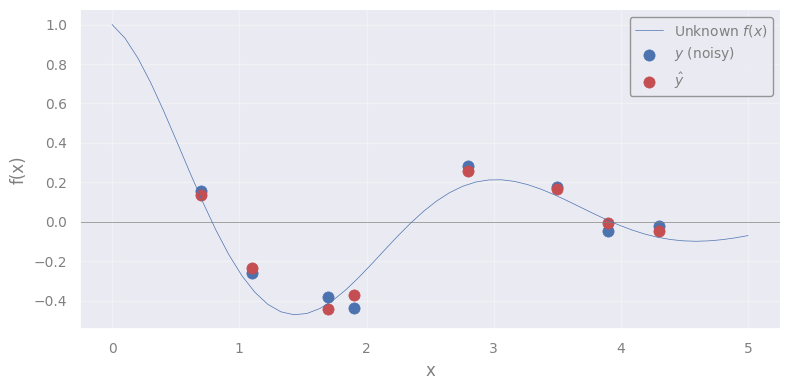

In [11]:
yhat = gpr.predict(X_train)

xx = np.linspace(0, 5, 50)

plt.figure()
plt.axhline(y=0, lw=0.5, c='grey')
plt.plot(xx, f(xx), c='C0', lw=0.5, label="Unknown $f(x)$")
plt.scatter(X_train.flatten(), y_train, c='C0', s=65, lw=0.5, label=r"$y$ (noisy)")
plt.scatter(X_train.flatten(), yhat,    c='C3', s=65, lw=0.5, label=r"$\hat{y}$")
'''NOTE: We need to flatten `X_train` for the plot, since it is 2D'''
plt.xlabel('x')
plt.ylabel('f(x)')

plt.legend()
plt.show()

You know what, let's predict for a <u>new</u> test point $x_*$ !

No, better, for <u>50</u> test points in the interval 0 < $x_*$ < 5:

```python
    X_test = np.linspace(0, 5, 50).reshape(-1, 1)
```

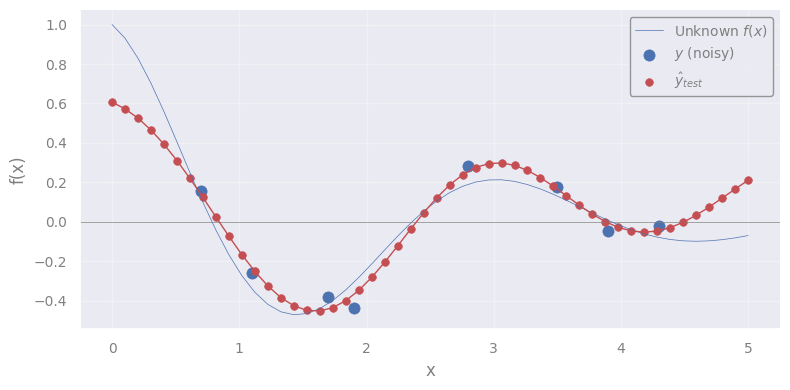

In [12]:
# Predict on new data
X_test = np.linspace(0, 5, 50).reshape(-1, 1)
yhat_test = gpr.predict(X_test)

plt.figure()
plt.axhline(y=0, lw=0.5, c='grey')
plt.plot(xx, f(xx), c='C0', lw=0.5, label="Unknown $f(x)$")
plt.scatter(X_train.flatten(), y_train,         c='C0', s=65, lw=0.5, label="$y$ (noisy)")
plt.scatter(X_test.flatten(),  yhat_test, c='C3', s=30, lw=0.5, label=r"$\hat{y}_{test}$")
plt.plot(X_test.flatten(), yhat_test, c='C3', lw=1)
'''NOTE: We need to flatten `X` and `X_test` for the plot, since they are 2D'''
plt.xlabel('x')
plt.ylabel('f(x)')

plt.legend()
plt.show()

**Q:** What we are seeing here?

It is the **mean function** $m(x)$ $\leftrightarrow$ the most probable function that describes the true $f(x)$

Remember the [interpretation](#Interpretation) ?

$$
\text{posterior mean} ~~~~~~ m_*^{\text{post}} = m_* + k_*\,\bigl(K + \sigma_n^2\,I\bigr)^{-1}\,\bigl(\text{\textbf{y}} - \text{\textbf{m}}\bigr)
$$
> _is our best estimate for the function values at the test inputs $x_*$_


If there is a "mean", there must be uncertainty around it:

$$
\text{posterior covariance} ~~~~~~ \Sigma_*^{\text{post}} = k_{**} - k_*\,\bigl(K + \sigma_n^2\,I\bigr)^{-1}\,k_*^T
$$

> _quantifies our uncertainty about these estimates_

<hr style="height:0.5px; border:none; color:lightgray; background-color:lightgray;">

We can extract it like this (_full covariance matrix_):
```python
    yhat_test, yhat_test_cov = gpr.predict(X_test, return_cov=True)
```

or like this (_only diagonal terms, i.e. standard deviations at each $x_*$_):
```python
    yhat_test, yhat_test_std = gpr.predict(X_test, return_std=True)
```

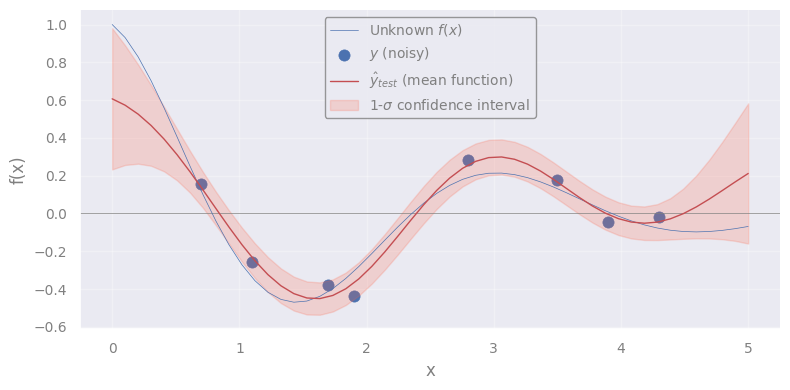

In [13]:
yhat_test, yhat_test_std = gpr.predict(X_test, return_std=True)

plt.figure()
plt.axhline(y=0, lw=0.5, c='grey')
plt.plot(xx, f(xx), c='C0', lw=0.5, label="Unknown $f(x)$")
plt.scatter(X_train.flatten(), y_train, c='C0', s=65, lw=0.5, label="$y$ (noisy)")
plt.plot(X_test.flatten(), yhat_test, c='C3', lw=1, label=r"$\hat{y}_{test}$ (mean function)")
'''NOTE: We need to flatten `X` and `X_test` for the plot, since they are 2D'''
plt.fill_between(
    X_test.ravel(),
    yhat_test - yhat_test_std,
    yhat_test + yhat_test_std,
    alpha=0.2,
    color='tomato',
    label=r'1-$\sigma$ confidence interval'
)
plt.xlabel('x')
plt.ylabel('f(x)')

plt.legend()
plt.show()

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">

#  In-class Exercise [45 min]

**Objective:** Fill-in missing pixels in an image. 

**Dataset:** An astronomical image.
</div>    

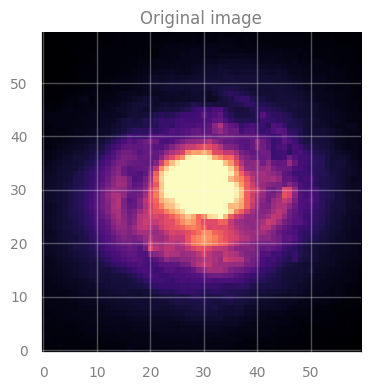

In [14]:
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import requests
from io import BytesIO
from skimage.transform import rescale

# Download NGC 1300 galaxy image from HST archive (FITS format)
fits_url = "https://hla.stsci.edu/cgi-bin/fitscut.cgi?red=hst_08597_11_wfpc2_f606w_pc&size=ALL&format=fits&config=ops"
response = requests.get(fits_url)
fits_file = BytesIO(response.content)

# Load the FITS image
data_fits = fits.getdata(fits_file)

# Crop image around galaxy
data_crop = data_fits[350:650, 425:725]

# Downscale the image (for faster computations)
scale_factor = 5
data = rescale(data_crop, 1/scale_factor, anti_aliasing=True, preserve_range=True).astype(data_crop.dtype)

# > Figure
fig, axes = plt.subplots(nrows=1, ncols=1)
axes = [axes]

# Apply ZScale interval for color scaling
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(data)

axes[0].set_title("Original image", fontsize=12)
axes[0].imshow(data, cmap='magma', origin='lower', vmin=vmin, vmax=vmax)

plt.tight_layout()
plt.show()

<u>IMPORTANT:</u><br>

> In this image, each pixel has an associated value $\rightarrow$ indicated by the color.

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">

This is our original data, the image for galaxy NGC 1300. 

But, we will "**corrupt**" it by creating holes in it.
</div>    

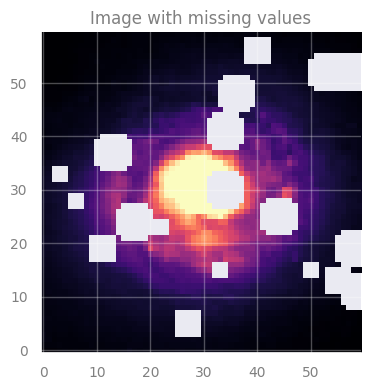

In [15]:
# Generate `n_holes` random circular gaps and set their values to np.nan
rng = np.random.default_rng(seed=2)
masked_data = data.copy()
n_holes = 20

rows, cols = data.shape
for _ in range(n_holes):
    x, y = rng.integers(0, cols), rng.integers(0, rows)
    radius = rng.integers(2, 5) # we add holes of 2 to 5 pixels at random
    y_grid, x_grid = np.ogrid[:rows, :cols]
    mask = (x_grid - x) ** 2 + (y_grid - y) ** 2 < radius ** 2
    masked_data[mask] = np.nan

'''NOTE:
    If we create too many holes (`n_holes`) or too large holes (`radius`),
    we may not have enough data to properly fit the data.

    You may experiment with these quantities and see the effect on the
    final result.
'''

# > Figure
fig, axes = plt.subplots(nrows=1, ncols=1)
axes = [axes]

# Apply ZScale interval for color scaling
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(data)

axes[0].set_title("Image with missing values", fontsize=12)
axes[0].imshow(masked_data, cmap='magma', origin='lower', vmin=vmin, vmax=vmax)

plt.tight_layout()
plt.show()

<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">

**Task:** Use GP to create a model that can **predict** the missing values.

_In particular, you must:_

1. **Train** the GP model
2. **Predict** on missing data
3. Use your predictions to **color** the missing spots in the image!

**Hint:**
For step 3, when you need to create an image with your predictions, you literally have to invert the creation of `y_test` (_see next block_)


</div>

**Q:** How can we prepare the data for GP? (_in-class discussion_)

<div class="alert alert-danger" role="alert" style="border-radius: 8px; padding: 10px;">
<details>
    
<b><summary>[Spoiler] (click here to expand)</summary></b>
    
We can place the pixel coordinates in the matrix $\rightarrow$ **X**

.. and the corresponding values (_color, in the image_) in the array $\rightarrow$ **y**

</details>
</div>



In [16]:
from pandas import option_context

# Put the coordinates of valid and invalid pixels in X ...
X_train = np.column_stack(np.where(~np.isnan(masked_data)))  # Coordinates of pixels that are NOT NaN
X_test  = np.column_stack(np.where(np.isnan(masked_data)))   # Coordinates of pixels that are NaN

# Put the values of valid and invalid pixels in y ...
y_train = data[np.where(~np.isnan(masked_data))]
y_test  = data[np.where(np.isnan(masked_data))]

with option_context("display.max_rows", 4):
    print('Train data:')
    display(pd.DataFrame(np.column_stack((X_train, y_train)), columns=['X1', 'X2', 'y']))
    print('Test data:')
    display(pd.DataFrame(np.column_stack((X_test, y_test)), columns=['X1', 'X2', 'y']))

Train data:


,X1,X2,y
0,0.0,0.0,0.066435
1,0.0,1.0,0.068779
...,...,...,...
3063,59.0,58.0,0.049804
3064,59.0,59.0,0.050841


Test data:


,X1,X2,y
0,3.0,25.0,0.146869
1,3.0,26.0,0.146841
...,...,...,...
533,58.0,41.0,0.104825
534,58.0,42.0,0.100024


<div class="alert alert-warning" role="alert" style="border-radius: 8px; padding: 10px">

<i>You can now proceed with the GP code ...</i>

</div>

## Food-for-thought

**<u>Interpretation</u>**

> _Why GP works "reasonably well" here?_

GP uses a kernel $k(x_i, x_j)$ which represents the correlation between $f(x_i)$ and $f(x_j)$

**Q:** What is $f(x_i)$ and $f(x_j)$, in the case of our image?

<div class="alert alert-danger" role="alert" style="border-radius: 8px; padding: 10px;">
<details>
    
<b><summary>[Spoiler] (click here to expand)</summary></b>
    
The pixel values (_colors_) !
</details>
</div>

So the question becomes: are the pixel values at $x_i$ and $x_j$ correlated at all?

$\rightarrow$ Yes! Because the galaxy light profile changes smoothly!

**<u>Uncertainties</u>**

> _What is the uncertainty on the prediction?_

We filled the image with the **mean** predicted value.

But GP also provides **standard deviation**.

$\rightarrow$ How could we display that ?

In [ ]:
###EOF